In [1]:
# VGG 16

In [1]:
# neccesary libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input
from keras.layers import (Dense, Dropout,concatenate, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,Input,GlobalAveragePooling2D,
GlobalMaxPooling2D,ZeroPadding2D,AveragePooling2D,Reshape,Convolution2D)
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils import layer_utils
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.utils import class_weight
from sklearn import model_selection

from glob import glob
from shutil import copyfile
import pandas as pd
from os import listdir
import fnmatch
import numpy as np
import random
import cv2

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from PIL import Image
from pandas import DataFrame

from time import time

Using TensorFlow backend.


In [2]:
# extract all the images recursively
dataset = glob('/projectnb/cs542sp/idc_classification/data/*/*/*.png', recursive=True)

class0 = fnmatch.filter(dataset, '*class0.png')
class1 = fnmatch.filter(dataset, '*class1.png')

# print("Negative %s \n" %class0[0:5]) #check the print output match our 

In [3]:
# estabilish the dataframe to be used later
data = pd.DataFrame(dataset, columns=['path'])

# get id of the image *.png
def extract_id(x):
    temp = x.split('/')
    return temp[-1]
# get label of the image 0 or 1
def extract_label(x):
    return x[-5]

data['id'] = data['path'].apply(extract_id) # add id after path
data['label'] = data['id'].apply(extract_label) # add label after id
data.head() # show the first 5 row

,path,id,label
0,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1351_y1551_class1.png,1
1,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1751_y1001_class1.png,1
2,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1101_y1601_class1.png,1
3,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1151_y1601_class1.png,1
4,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1351_y1051_class1.png,1


In [4]:
shape = data.shape
print(shape)
data['label'].value_counts()
print(data['path'].shape)

(277524, 3)
(277524,)


In [8]:
def readImage(path):
    im = Image.open(path,  'r')
    return np.array(im)

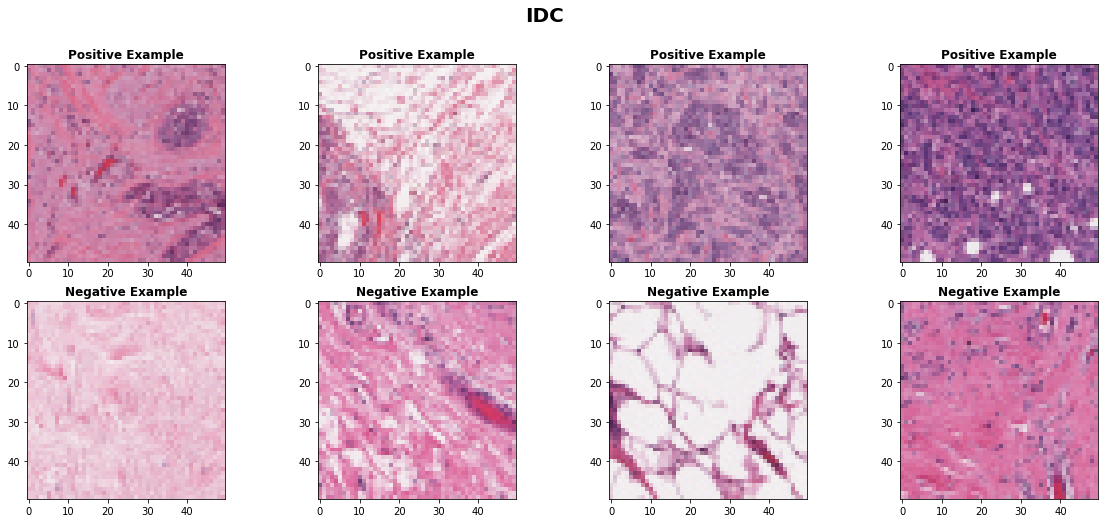

In [8]:
random.seed(0)
positive_indices = list(np.where(data["label"] == "1")[0])
negative_indices = list(np.where(data["label"] == "0")[0])
rand_pos_inds = random.sample(positive_indices, 4)
rand_neg_inds = random.sample(negative_indices, 4)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('IDC',fontsize=20, fontweight='bold')

for i in range(0, 4):
    ax[0,i].imshow(readImage(data.iloc[rand_pos_inds[i],0]))
    ax[0,i].set_title("Positive Example", fontweight='bold')
    
    ax[1,i].imshow(readImage(data.iloc[rand_neg_inds[i],0]))
    ax[1,i].set_title("Negative Example", fontweight='bold')

plt.show()
random.shuffle(positive_indices)
random.shuffle(negative_indices)

In [25]:
# read the image and append to the dataframe
# data['matrix'] = data['path'].apply(readImage)


In [26]:
# flip the positive images then append to the dataframe

# data=pd.read_pickle("./processedData")

random.seed(0)
def flipImage(path):
    img = readImage(path)
    mode = random.randint(-1,1)
    return cv2.flip(img, mode)

# mask = (data['label'] == '1')
# z_valid = data[mask].copy()
# z_valid['matrix'] = z_valid['path'].apply(flipImage)

# # Concat the two df to make a more balanced df, also reset index
# data=pd.concat([data, z_valid]).reset_index(drop=True)

In [28]:
# # store the result
# data.to_pickle("./balancedData")

In [38]:
# data=pd.read_pickle("./balancedData")
# data = data.sample(frac=1).reset_index(drop=True)
# data.to_pickle("./balancedData_shuffled")

In [2]:
data=pd.read_pickle("./balancedData_shuffled")

In [3]:
## get image data from dataframe
def procData(lower_ind, upper_ind):
    x = []
    y = []
    for ind in range(lower_ind, upper_ind):
        path = data['path'][ind]
        label = data['label'][ind]
        image = data['matrix'][ind]
        shape = image.shape
        if shape == (50,50,3):
            x.append(image)
            if label == '1':
                y.append(1)
            else:
                y.append(0)
    return x, y

In [16]:
## Read 10000 images for debugging
X,Y = procData(0, 20000)
test_X, test_Y = procData(20000, 24000)
print("idc(+) :", Y.count(1))
print("idc(-) :", Y.count(0))
print("Testing size :", len(test_Y))
print("Training data shape :", X[0].shape)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y


idc(+) : 8765
idc(-) : 11113
Testing size : 3975
Training data shape : (50, 50, 3)


In [17]:
X2 = df["images"]
Y2 = df["labels"]
X = np.array(X)
Y = np.array(Y)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

train_X = X/255.0 # scale to [0,1]
test_X = test_X/255.0 # scale to [0,1]

trainHot_Y = to_categorical(Y, num_classes = 2)
testHot_Y = to_categorical(test_Y, num_classes = 2)
# cweight = class_weight.compute_class_weight('balanced',np.unique(Y),Y)


In [18]:
print("vgg16 executing " )
def vgg_like(train_X, trainHot_Y, test_X, testHot_Y):
    
    input_shape = (50,50,3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
    
    es= EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=0, mode='auto')
    hist = model.fit(train_X,trainHot_Y, batch_size=128, epochs=20, callbacks = [es], validation_split =0.2)

    score = model.evaluate(test_X, testHot_Y, batch_size=128) # original basize 32
    # print(hist.history)

    # Plot training & validation accuracy values

    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.close()

    # Plot training & validation loss values
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save model
    model.save_weights('xxx.h5')
    
vgg_like(train_X, trainHot_Y, test_X, testHot_Y)

vgg16 executing 
Train on 15902 samples, validate on 3976 samples
Epoch 1/10
15902/15902 [==============================] - 60s - loss: 0.6477 - acc: 0.6350 - val_loss: 0.6295 - val_acc: 0.6308
Epoch 2/10
15902/15902 [==============================] - 59s - loss: 0.5765 - acc: 0.7130 - val_loss: 0.5930 - val_acc: 0.6821
Epoch 3/10
15902/15902 [==============================] - 58s - loss: 0.5286 - acc: 0.7560 - val_loss: 0.5932 - val_acc: 0.6949
Epoch 4/10
15902/15902 [==============================] - 58s - loss: 0.4944 - acc: 0.7725 - val_loss: 0.4827 - val_acc: 0.7822
Epoch 5/10
15902/15902 [==============================] - 58s - loss: 0.4750 - acc: 0.7807 - val_loss: 0.4674 - val_acc: 0.8041
Epoch 6/10
15902/15902 [==============================] - 59s - loss: 0.4649 - acc: 0.7881 - val_loss: 0.4680 - val_acc: 0.7925
Epoch 7/10
3968/3975 [============================>.] - ETA: 0s

In [71]:
myVGG16(train_X, trainHot_Y, test_X, testHot_Y)

ValueError: Error when checking target: expected dense_12 to have shape (None, 1000) but got array with shape (994, 2)

In [6]:
#--------------------------------------------#
#|            VGG 16 model                  |#
#--------------------------------------------#
def myVGG16(X_train, Y_trainHot,X_test, Y_testHot):
    batch = 128
    classes =2
    epochs = 100
    tb = TensorBoard(log_dir = "logs/{}".format(time()))
    channels = 3
    
    input_shape = (50,50,3)
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),strides=2,activation='relu', input_shape=input_shape))
    model.add(Conv2D(64,(3,3),strides=2,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128,(3,3),strides=2,padding='same',activation='relu'))
    model.add(Conv2D(128,(3,3),strides=2,padding='same',activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(256,(3,3),strides=2,padding='same',activation='relu'))
    model.add(Conv2D(256,(3,3),strides=2,padding='same',activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256,(3,3),strides=2,padding='same',activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
    model.add(Conv2D(512,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
    model.add(Conv2D(512,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation = 'softmax'))
    es= EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2, verbose=0, mode='auto')
    model.compile(loss= keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics = ['accuracy'])
    
    hist =model.fit(train_X,trainHot_Y, batch_size=128, epochs=10, callbacks = [es], validation_split =0.2)

    score = model.evaluate(test_X, testHot_Y, batch_size=128) # original basize 32
    # print(hist.history)

    # Plot training & validation accuracy values

    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig("1accuracy.png")
    plt.show()
    plt.close()

    # Plot training & validation loss values
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig("1loss.png")

    # Save model
    model.save_weights('xxx.h5')
    return model
              